# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file (make sure the path is correct if your file is elsewhere)
# df = pd.read_csv("data/bquxjob_6d1f9d31_19685a5680f.csv")
df = pd.read_csv("data/bq-results-20250430-073657-1745998667647.csv")
# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# Data Overview

In [53]:
# Number of unique assets
num_assets = df['asset'].nunique()

# Number of unique routes
num_routes = df['route_id'].nunique()

print(f"Number of unique assets: {num_assets}")
print(f"Number of unique routes: {num_routes}")

Number of unique assets: 57
Number of unique routes: 547


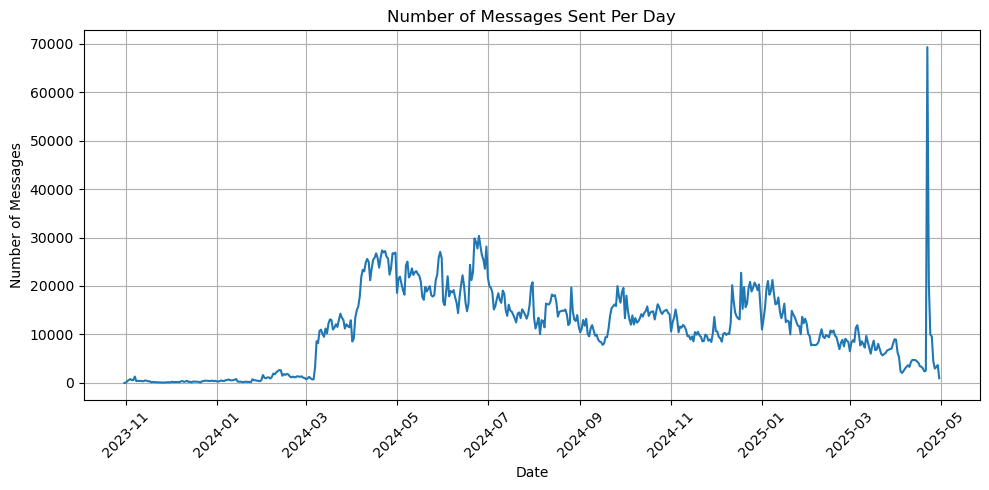

In [54]:
# Extract the date only (no time)
df['date'] = df['time'].dt.date

# Count number of messages per day
messages_per_day = df.groupby('date').size()

# Plotting the messages per day as a line chart
plt.figure(figsize=(10, 5))
messages_per_day.plot(kind='line')
plt.title('Number of Messages Sent Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2023-10-31 20:29:20+0000', tz='UTC'),
       Timestamp('2023-10-31 20:31:19+0000', tz='UTC'),
       Timestamp('2023-10-31 21:22:41+0000', tz='UTC'), ..., NaT, NaT,
       NaT], dtype=object)

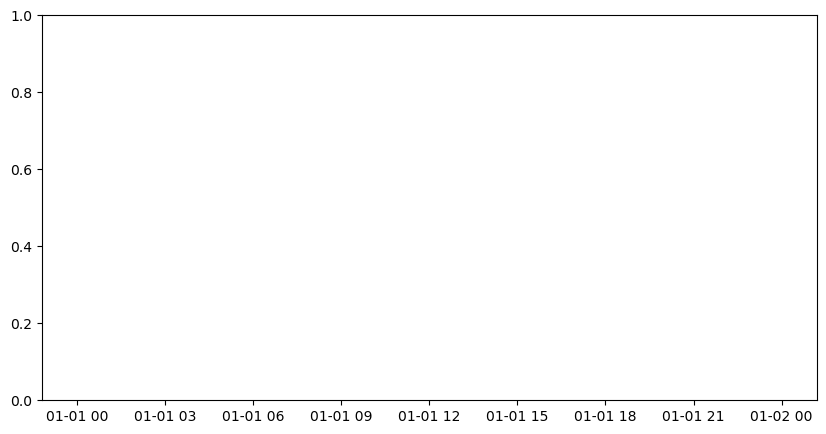

In [55]:
df_sorted = df.sort_values('time')
df_sorted['cumulative_messages'] = range(1, len(df_sorted) + 1)

plt.figure(figsize=(10, 5))
plt.plot(df_sorted['time'], df_sorted['cumulative_messages'])
plt.title('Cumulative Messages Over Time')
plt.xlabel('Time')
plt.ylabel('Total Messages')
plt.grid(True)
plt.tight_layout()

In [56]:
total_messages = len(df)
print(f"Total messages sent: {total_messages}")

Total messages sent: 6056859


In [57]:
messages_per_route = df['route_id'].value_counts()
print(messages_per_route)

route_id
injective-protocol/inevm-injective        1086463
celestia/arbitrum-neutron                 1064601
celestia/mantapacific-neutron              369020
celestia/forma-stride                      338985
solana/eclipsemainnet-solanamainnet        261601
                                           ...   
ethereum/blast-scroll                           1
openusdt/ink-mode                               1
renzo-restaked-eth/ethereum-worldchain          1
usd-coin/bsc-polygon                            1
ethereum/blast-ethereum                         1
Name: count, Length: 547, dtype: int64


In [58]:
messages_per_asset = df['asset'].value_counts()
print(messages_per_asset)

asset
celestia                         1813870
ethereum                         1683161
injective-protocol               1086463
renzo-restaked-eth                613265
solana                            292330
usd-coin                          245116
hyperlane                          98362
magic                              79820
openusdt                           32889
tether                             25230
eclipse-fi                         22888
official-trump                     20345
dogwifcoin                          6938
orca                                4753
kyros-restaked-sol                  4340
aixbt-by-virtuals                   3568
artela-network                      3101
stride-staked-tia                   2996
bonk                                1830
polygon-ecosystem-token             1766
game-by-virtuals                    1498
sonic-svm                           1318
renzo-restaked-sol                  1292
cod3x                               1272
elixir-deu

Text(145.72222222222223, 0.5, 'Day of Week')

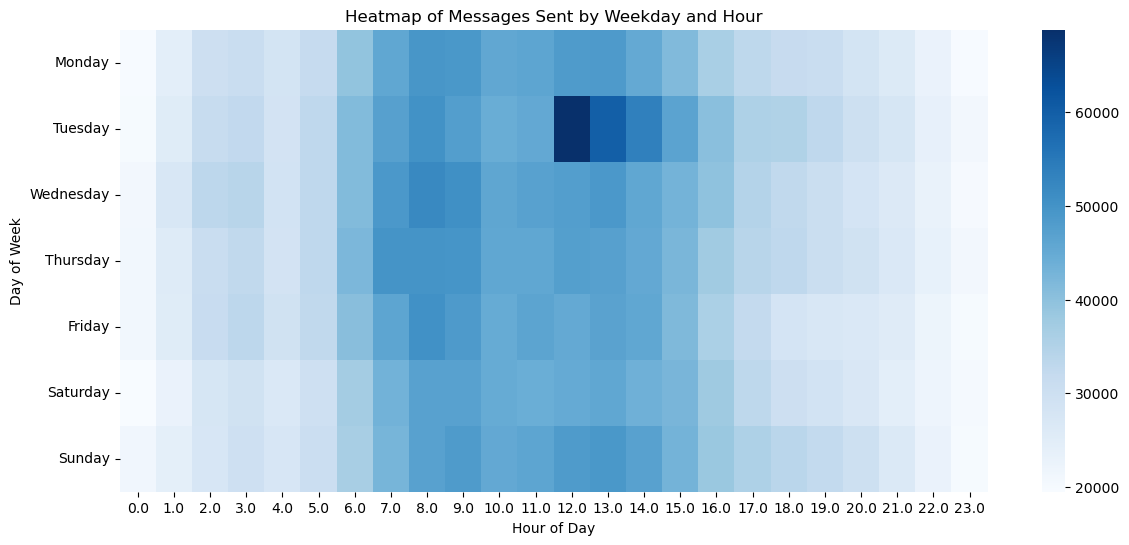

In [124]:
# Extract weekday and hour from the time column
df['weekday'] = df['time'].dt.day_name()
df['hour'] = df['time'].dt.hour

# Create a pivot table with weekdays as rows and hours as columns
heatmap_data = df.pivot_table(index='weekday', columns='hour', values='route_id', aggfunc='count', fill_value=0)

# Reorder weekdays to start from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

# Plotting the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="Blues", fmt='d')
plt.title('Heatmap of Messages Sent by Weekday and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

# Cohort Analysis

In [61]:
# Ensure 'time' is datetime and get the date
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.floor('D')

# STEP 1: Get first and last active day per route
route_activity_span = df.groupby('route_id')['date'].agg(['min', 'max']).reset_index()
route_activity_span['days_active'] = (route_activity_span['max'] - route_activity_span['min']).dt.days

# STEP 2: Build full index with all valid (route, days_since_first_message)
full_index = pd.concat([
    pd.DataFrame({
        'route_id': [row['route_id']] * (row['days_active'] + 1),
        'days_since_first_message': list(range(row['days_active'] + 1))
    })
    for _, row in route_activity_span.iterrows()
], ignore_index=True)

# STEP 3: Create actual cohort stats from main df
df['cohort'] = df.groupby('route_id')['date'].transform('min')
df['days_since_first_message'] = (df['date'] - df['cohort']).dt.days
cohort_stats = df.groupby(['route_id', 'days_since_first_message']).size().reset_index(name='messages_sent')

# STEP 4: Merge full index with actual data and fill missing days with 0
cohort_complete = pd.merge(full_index, cohort_stats, on=['route_id', 'days_since_first_message'], how='left')
cohort_complete['messages_sent'] = cohort_complete['messages_sent'].fillna(0).astype(int)

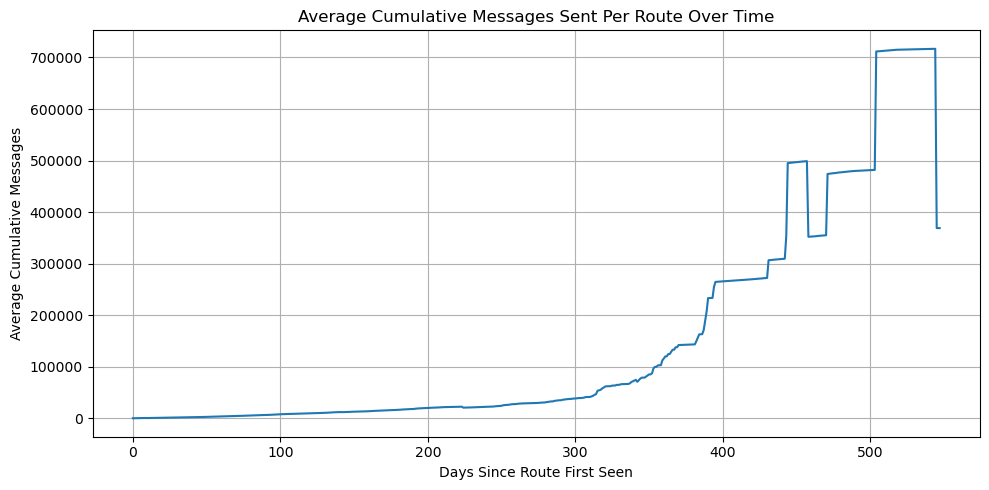

In [62]:
# Create cumulative messages per route over time
cohort_cumulative = cohort_complete.copy()
cohort_cumulative['cumulative_messages'] = cohort_cumulative.groupby('route_id')['messages_sent'].cumsum()

# Calculate the average cumulative messages per day since launch across all routes
average_cumulative = cohort_cumulative.groupby('days_since_first_message')['cumulative_messages'].mean()

# Plot the average cumulative growth curve
plt.figure(figsize=(10, 5))
plt.plot(average_cumulative.index, average_cumulative.values)
plt.title('Average Cumulative Messages Sent Per Route Over Time')
plt.xlabel('Days Since Route First Seen')
plt.ylabel('Average Cumulative Messages')
plt.grid(True)
plt.tight_layout()
plt.show()


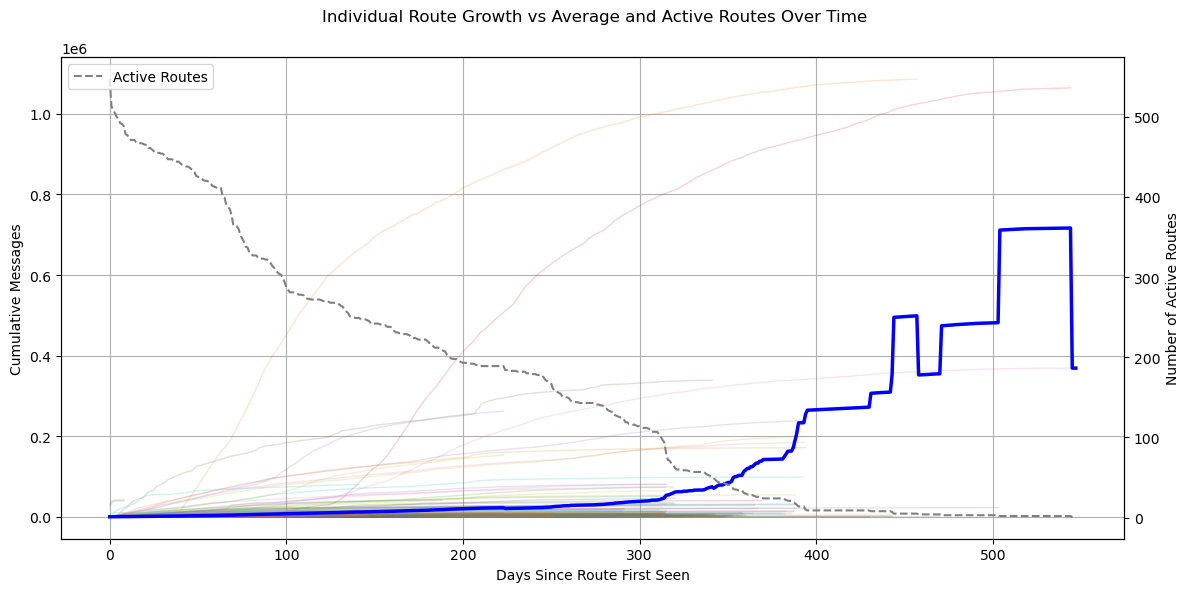

In [63]:
# Create cumulative message trajectories for each route
cohort_cumulative = cohort_complete.copy()
cohort_cumulative['cumulative_messages'] = cohort_cumulative.groupby('route_id')['messages_sent'].cumsum()

# Average and active routes per day (again for overlay)
average_cumulative = cohort_cumulative.groupby('days_since_first_message')['cumulative_messages'].mean()
active_routes_per_day = cohort_cumulative.groupby('days_since_first_message')['route_id'].nunique()

# Plot all individual trajectories, average line, and active routes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot individual routes
for route_id, group in cohort_cumulative.groupby('route_id'):
    ax1.plot(group['days_since_first_message'], group['cumulative_messages'], alpha=0.2, linewidth=1)

# Plot average cumulative messages
ax1.plot(average_cumulative.index, average_cumulative.values, color='blue', linewidth=2.5, label='Average')

# Primary Y-axis settings
ax1.set_xlabel('Days Since Route First Seen')
ax1.set_ylabel('Cumulative Messages')
ax1.tick_params(axis='y')
ax1.grid(True)

# Secondary Y-axis: active routes per day
ax2 = ax1.twinx()
ax2.plot(active_routes_per_day.index, active_routes_per_day.values, color='gray', linestyle='dashed', label='Active Routes')
ax2.set_ylabel('Number of Active Routes')
ax2.tick_params(axis='y')

# Title and legend
fig.suptitle('Individual Route Growth vs Average and Active Routes Over Time')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


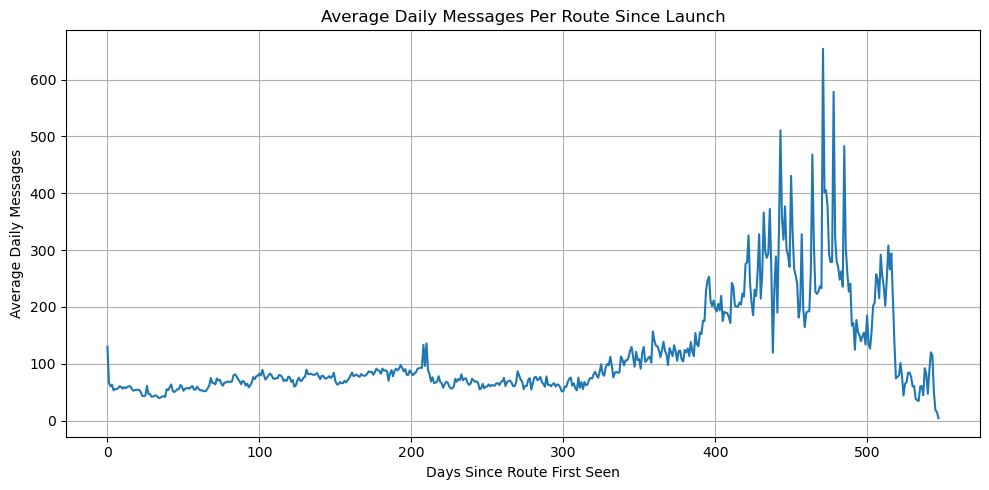

In [72]:
# Copy and prep the data
traction_df = cohort_complete.copy()

# Calculate average messages per day across all routes
average_daily_messages = traction_df.groupby('days_since_first_message')['messages_sent'].mean()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(average_daily_messages.index, average_daily_messages.values)
plt.title('Average Daily Messages Per Route Since Launch')
plt.xlabel('Days Since Route First Seen')
plt.ylabel('Average Daily Messages')
plt.grid(True)
plt.tight_layout()
plt.show()


# K-Means Clustering

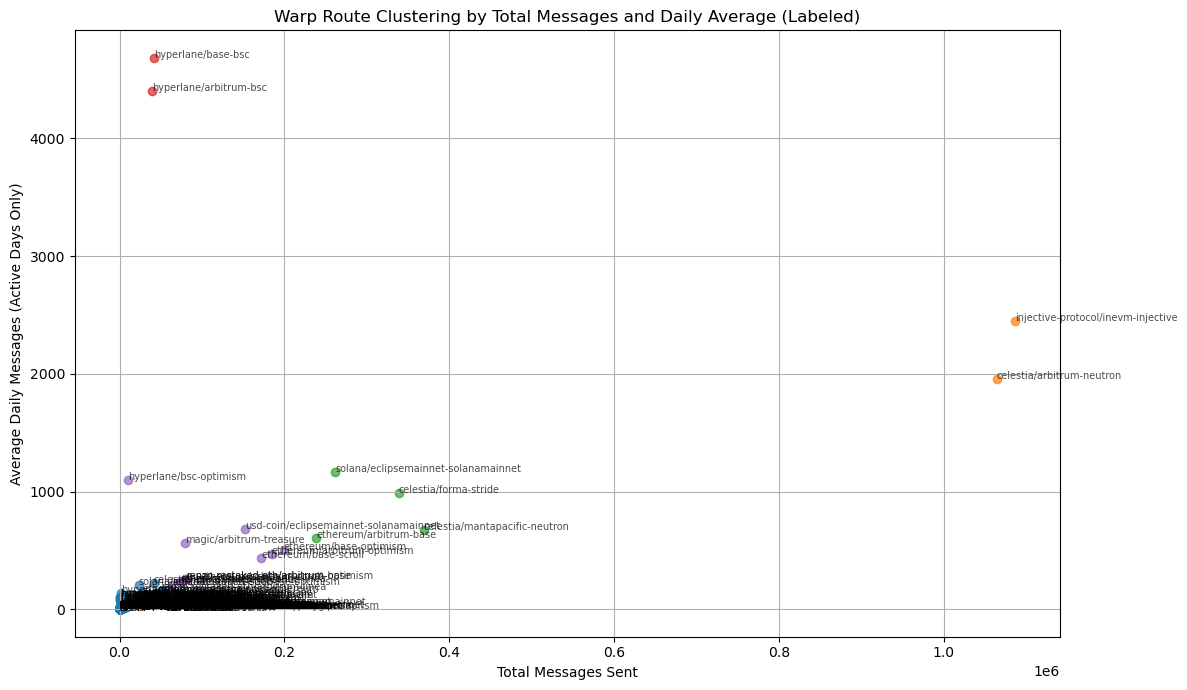

In [106]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# STEP 1: Compute total and average messages per route
route_stats = cohort_complete.copy().groupby('route_id').agg(
    total_messages=('messages_sent', 'sum'),
    active_days=('messages_sent', lambda x: (x > 0).sum())
).reset_index()
route_stats['daily_avg'] = route_stats['total_messages'] / route_stats['active_days']

# STEP 2: Normalize for clustering
features = route_stats[['total_messages', 'daily_avg']]
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# STEP 3: Apply KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
route_stats['cluster'] = kmeans.fit_predict(features_normalized)

# STEP 4: Plot results with labels
plt.figure(figsize=(12, 7))
for _, row in route_stats.iterrows():
    plt.scatter(row['total_messages'], row['daily_avg'], c=f'C{row["cluster"]}', alpha=0.7)
    plt.text(row['total_messages'], row['daily_avg'], row['route_id'], fontsize=7, alpha=0.7)

plt.title('Warp Route Clustering by Total Messages and Daily Average (Labeled)')
plt.xlabel('Total Messages Sent')
plt.ylabel('Average Daily Messages (Active Days Only)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [107]:
route_stats

,route_id,total_messages,active_days,daily_avg,cluster
0,ELIZA/solanamainnet-soon,6,3,2.000000,0
1,Pnut/solanamainnet-soon,6,3,2.000000,0
2,ai16z/solanamainnet-soon,22,11,2.000000,0
3,aixbt-by-virtuals/base-form,3556,106,33.547170,0
4,artela-network/artela-base,2473,95,26.031579,0
...,...,...,...,...,...
542,wrapped-bitcoin/ethereum-hyperevm,114,27,4.222222,0
543,wrapped-bitcoin/mode-scroll,2,1,2.000000,0
544,wrapped-bitcoin/mode-zeronetwork,2,1,2.000000,0
545,wrapped-bitcoin/scroll-zeronetwork,1,1,1.000000,0


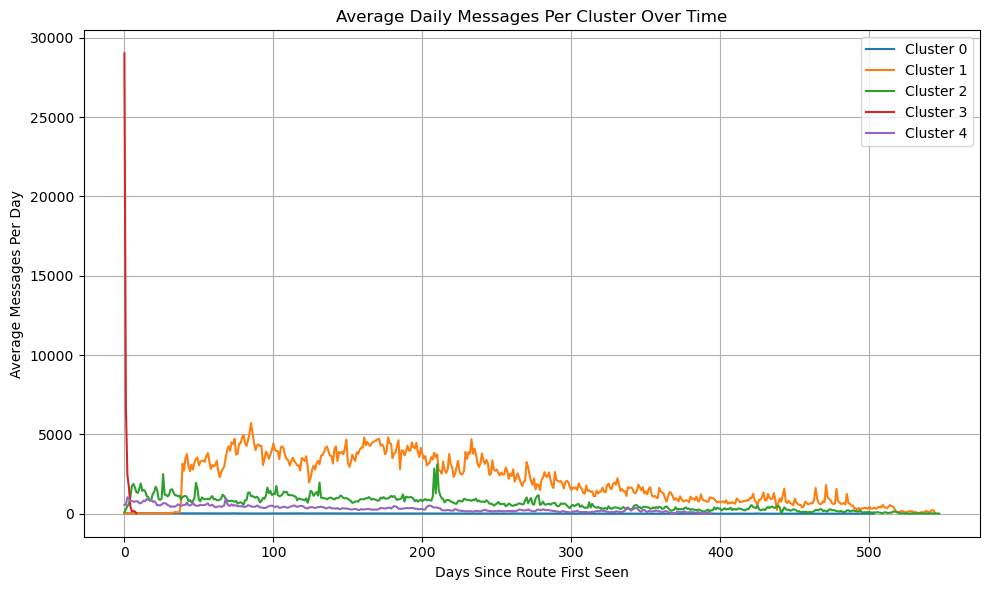

In [108]:
# Merge cluster info back into cohort_complete data
clustered_cohort = pd.merge(cohort_complete, route_stats[['route_id', 'cluster']], on='route_id', how='left')

# Calculate average daily messages per cluster
avg_daily_by_cluster = clustered_cohort.groupby(['cluster', 'days_since_first_message'])['messages_sent'].mean().reset_index()

# Plot average daily messages per cluster
plt.figure(figsize=(10, 6))
for cluster_id in sorted(avg_daily_by_cluster['cluster'].unique()):
    cluster_data = avg_daily_by_cluster[avg_daily_by_cluster['cluster'] == cluster_id]
    plt.plot(cluster_data['days_since_first_message'], cluster_data['messages_sent'], label=f'Cluster {cluster_id}')

plt.title('Average Daily Messages Per Cluster Over Time')
plt.xlabel('Days Since Route First Seen')
plt.ylabel('Average Messages Per Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

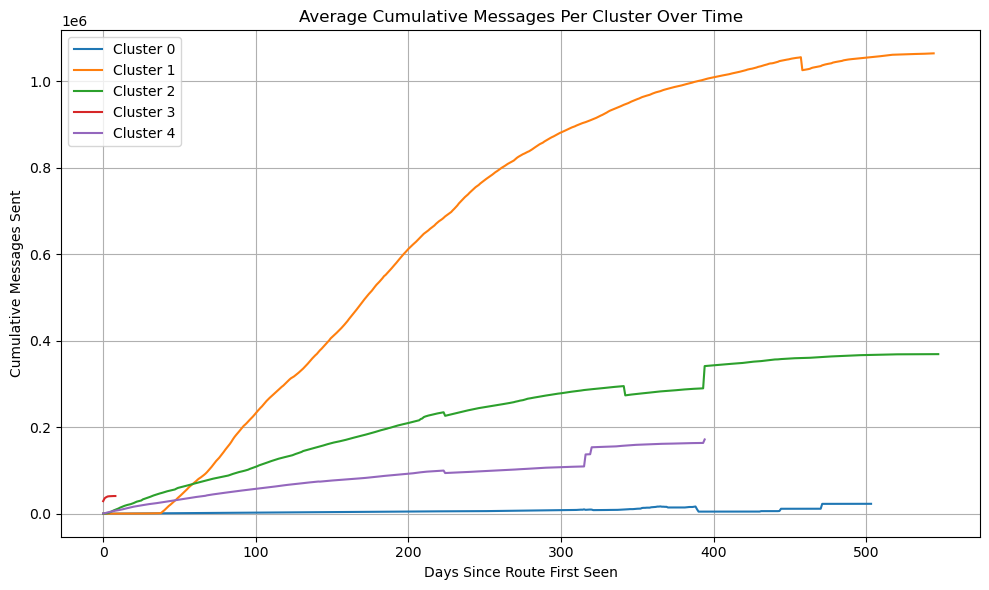

In [109]:
# Calculate cumulative messages per cluster over time
clustered_cohort['cumulative_messages'] = clustered_cohort.groupby(['route_id'])['messages_sent'].cumsum()

# Then average across all routes within each cluster and day
avg_cumulative_by_cluster = clustered_cohort.groupby(['cluster', 'days_since_first_message'])['cumulative_messages'].mean().reset_index()

# Plot cumulative average messages per cluster
plt.figure(figsize=(10, 6))
for cluster_id in sorted(avg_cumulative_by_cluster['cluster'].unique()):
    cluster_data = avg_cumulative_by_cluster[avg_cumulative_by_cluster['cluster'] == cluster_id]
    plt.plot(cluster_data['days_since_first_message'], cluster_data['cumulative_messages'], label=f'Cluster {cluster_id}')

plt.title('Average Cumulative Messages Per Cluster Over Time')
plt.xlabel('Days Since Route First Seen')
plt.ylabel('Cumulative Messages Sent')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


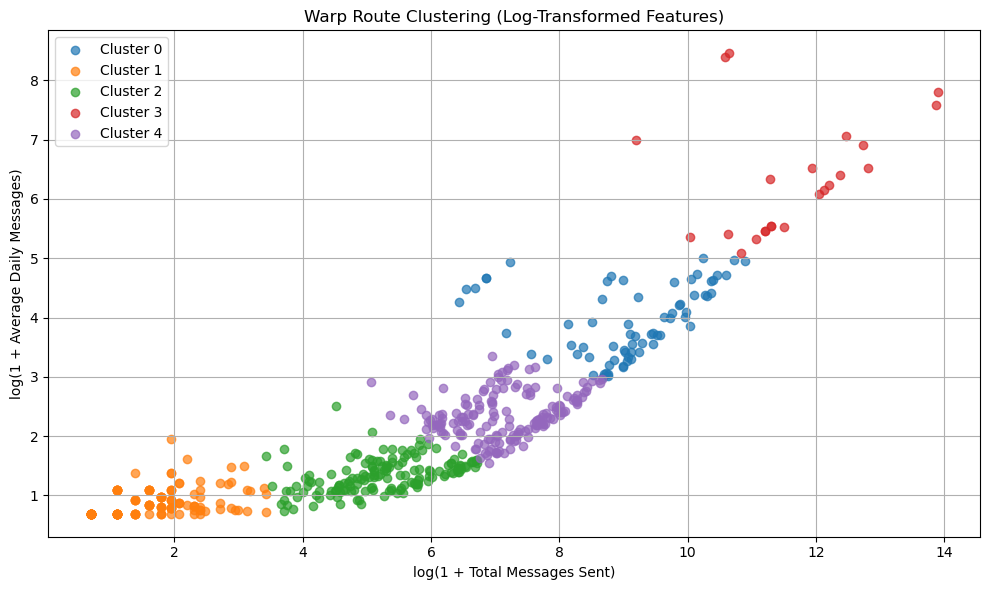

In [122]:
import numpy as np
# Apply log1p transform (log(x + 1)) to handle skew and zeros
route_stats['log_total_messages'] = np.log1p(route_stats['total_messages'])
route_stats['log_daily_avg'] = np.log1p(route_stats['daily_avg'])

# Normalize the log-transformed features
log_features = route_stats[['log_total_messages', 'log_daily_avg']]
log_features_normalized = scaler.fit_transform(log_features)

# Apply KMeans clustering on log-transformed, normalized features
kmeans_log = KMeans(n_clusters=5, random_state=42, n_init=10)
route_stats['cluster_log'] = kmeans_log.fit_predict(log_features_normalized)

# Plot the clustering result with log-transformed axes
plt.figure(figsize=(10, 6))
for cluster_id in sorted(route_stats['cluster_log'].unique()):
    cluster_data = route_stats[route_stats['cluster_log'] == cluster_id]
    plt.scatter(cluster_data['log_total_messages'], cluster_data['log_daily_avg'], label=f'Cluster {cluster_id}', alpha=0.7)

plt.title('Warp Route Clustering (Log-Transformed Features)')
plt.xlabel('log(1 + Total Messages Sent)')
plt.ylabel('log(1 + Average Daily Messages)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


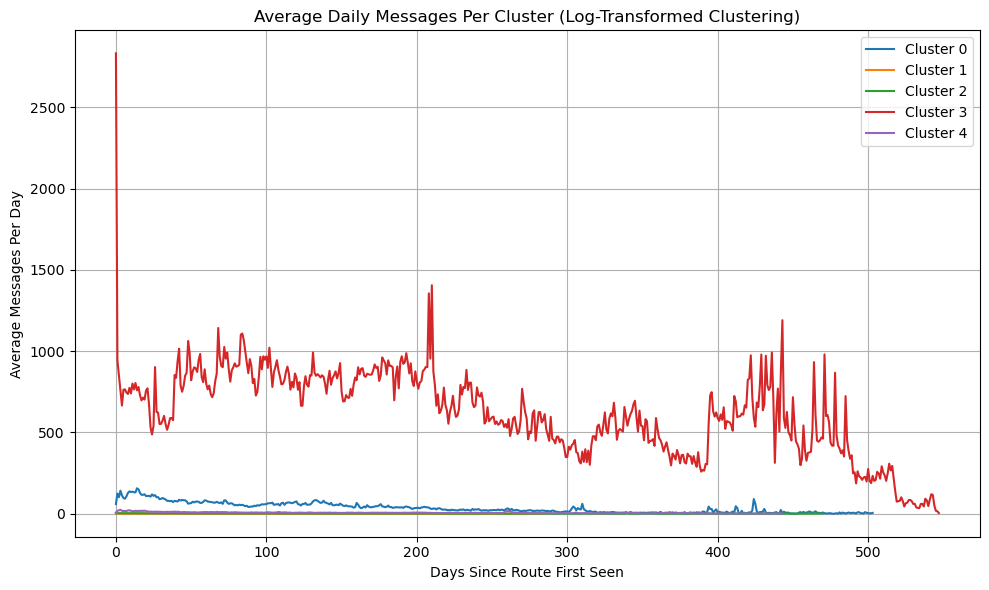

In [123]:
# Merge new log-based cluster assignments into cohort data
clustered_cohort_log = pd.merge(clustered_cohort, route_stats[['route_id', 'cluster_log']], on='route_id', how='left')

# Calculate average daily messages per log-based cluster
avg_daily_by_cluster_log = clustered_cohort_log.groupby(['cluster_log', 'days_since_first_message'])['messages_sent'].mean().reset_index()

# Plot daily average messages per log-based cluster
plt.figure(figsize=(10, 6))
for cluster_id in sorted(avg_daily_by_cluster_log['cluster_log'].unique()):
    cluster_data = avg_daily_by_cluster_log[avg_daily_by_cluster_log['cluster_log'] == cluster_id]
    plt.plot(cluster_data['days_since_first_message'], cluster_data['messages_sent'], label=f'Cluster {cluster_id}')

plt.title('Average Daily Messages Per Cluster (Log-Transformed Clustering)')
plt.xlabel('Days Since Route First Seen')
plt.ylabel('Average Messages Per Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

